# Gumbel Softmax / Concrete VAE with BayesFlow

Implements a categorical VAE using the technique introduced in [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables (Maddison et al. 2016)](https://arxiv.org/abs/1611.00712) and [Categorical Reparameterization with Gumbel-Softmax (Jang et al. 2016)](https://arxiv.org/abs/1611.01144). The VAE architecture shown here are a bit different than the models presented in the papers, this one has 1 stochastic 20x10-ary layer with 2-layer deterministic encoder/decoders and a fixed prior.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
slim=tf.contrib.slim
Bernoulli = tf.contrib.distributions.Bernoulli
OneHotCategorical = tf.contrib.distributions.OneHotCategorical
RelaxedOneHotCategorical = tf.contrib.distributions.RelaxedOneHotCategorical

In [4]:
# black-on-white MNIST (harder to learn than white-on-black MNIST)
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
batch_size=100
tau0=1.0 # initial temperature
K=10 # number of classes
N=200//K # number of categorical distributions
straight_through=False # if True, use Straight-through Gumbel-Softmax
kl_type='relaxed' # choose between ('relaxed', 'categorical')
learn_temp=False 

In [6]:
x=tf.placeholder(tf.float32, shape=(batch_size,784), name='x')
net = tf.cast(tf.random_uniform(tf.shape(x)) < x, x.dtype) # dynamic binarization
net = slim.stack(net,slim.fully_connected,[512,256])
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,N,K])
tau = tf.Variable(tau0,name="temperature",trainable=learn_temp)
q_y = RelaxedOneHotCategorical(tau,logits_y)
y = q_y.sample()
if straight_through:
  y_hard = tf.cast(tf.one_hot(tf.argmax(y,-1),K), y.dtype)
  y = tf.stop_gradient(y_hard - y) + y
net = slim.flatten(y)
net = slim.stack(net,slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
p_x = Bernoulli(logits=logits_x)
x_mean = p_x.mean()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The T

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [7]:
recons = tf.reduce_sum(p_x.log_prob(x),1)
logits_py = tf.ones_like(logits_y) * 1./K

if kl_type=='categorical' or straight_through:
  # Analytical KL with Categorical prior
  p_cat_y = OneHotCategorical(logits=logits_py)
  q_cat_y = OneHotCategorical(logits=logits_y)
  KL_qp = tf.contrib.distributions.kl(q_cat_y, p_cat_y)
else:
  # Monte Carlo KL with Relaxed prior
  p_y = RelaxedOneHotCategorical(tau,logits=logits_py)
  KL_qp = q_y.log_prob(y) - p_y.log_prob(y)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
KL = tf.reduce_sum(KL_qp,1)
mean_recons = tf.reduce_mean(recons)
mean_KL = tf.reduce_mean(KL)
loss = -tf.reduce_mean(recons-KL)


In [9]:
train_op=tf.train.AdamOptimizer(learning_rate=3e-4).minimize(loss)

In [10]:
data = []
with tf.train.MonitoredSession() as sess:
  for i in range(1,50000):
    batch = mnist.train.next_batch(batch_size)
    res = sess.run([train_op, loss, tau, mean_recons, mean_KL], {x : batch[0]})
    if i % 100 == 1:
      data.append([i] + res[1:])
    if i % 1000 == 1:
      print('Step %d, Loss: %0.3f' % (i,res[1]))
  # end training - do an eval
  batch = mnist.test.next_batch(batch_size)
  np_x = sess.run(x_mean, {x : batch[0]})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Step 1, Loss: 548.854
Step 1001, Loss: 203.035
Step 2001, Loss: 189.381
Step 3001, Loss: 169.423
Step 4001, Loss: 170.960
Step 5001, Loss: 160.140
Step 6001, Loss: 152.498
Step 7001, Loss: 151.986
Step 8001, Loss: 147.837
Step 9001, Loss: 143.620
Step 10001, Loss: 152.370
Step 11001, Loss: 153.835
Step 12001, Loss: 153.550
Step 13001, Loss: 144.877
Step 14001, Loss: 145.892
Step 15001, Loss: 148.855
Step 16001, Loss: 148.064
Step 17001, Loss: 148.798
Step 18001, Loss: 141.287
Step 19001, Loss: 152.284
Step 20001, Loss: 143.985
Step 21001, Loss: 141.890
Step 22001, Loss: 146.877
Step 23001, Loss: 148.500
Step 24001, Loss: 149.621
Step 25001, Loss: 148.384
Step 26001, Loss: 142.270
Step 27001, Loss: 147.691
Step 28001, Loss: 142.733
Step 29001, Loss: 140.724
Step 30001, Loss: 149.788
Step 31001, Loss: 144.614
Step 32001, Loss: 148.288
Step 33001, Loss: 137.242
Step 3400

In [11]:
data = np.array(data).T

Text(0.5, 1.0, 'KL')

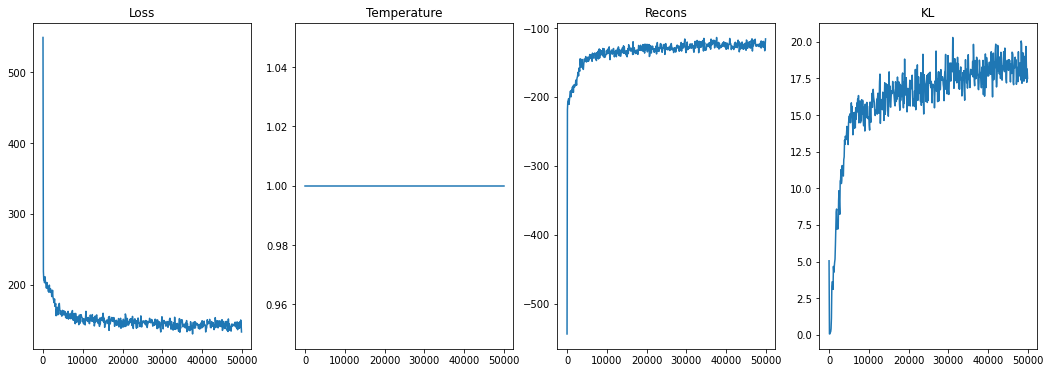

In [12]:
f,axarr=plt.subplots(1,4,figsize=(18,6))
axarr[0].plot(data[0],data[1])
axarr[0].set_title('Loss')

axarr[1].plot(data[0],data[2])
axarr[1].set_title('Temperature')

axarr[2].plot(data[0],data[3])
axarr[2].set_title('Recons')

axarr[3].plot(data[0],data[4])
axarr[3].set_title('KL')

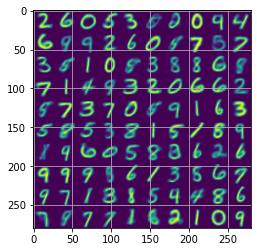

In [13]:
tmp = np.reshape(np_x,(-1,280,28)) # (10,280,28)
img = np.hstack([tmp[i] for i in range(10)])
plt.imshow(img)
plt.grid('off')